In [230]:
import pandas as pd
import numpy as  np
import pycaret
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [231]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [232]:
data = pd.read_csv('../../data/raw/01_homely_resort_listing.csv')
data.head()

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,cancellation_policy,guests_included,...,number_of_reviews,property_type,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,Unnamed: 25,price
0,6,"{""Cable TV"",Internet,""Wireless Internet"",""Air ...",0,2.5,Real Bed,1.0,3.0,1,moderate,1,...,1,House,10.0,10.0,10.0,100.0,10.0,Private room,NaN,$300.00
1,2,"{""Air Conditioning"",Heating,""Family/Kid Friend...",29,0.0,Futon,1.0,1.0,1,moderate,1,...,0,Camper/RV,NaN,NaN,NaN,NaN,NaN,Private room,NaN,$99.00
2,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,1.5,Real Bed,1.0,1.0,2,flexible,1,...,0,House,NaN,NaN,NaN,NaN,NaN,Private room,NaN,$100.00
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,1.5,Real Bed,1.0,1.0,2,flexible,1,...,0,House,NaN,NaN,NaN,NaN,NaN,Private room,NaN,$100.00
4,6,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",27,2.0,Real Bed,3.0,3.0,2,strict,1,...,0,House,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NaN,$599.00


In [233]:
data.shape

(5834, 27)

In [234]:
data.isna().sum()

accommodates                         0
amenities                            0
availability_30                      0
bathrooms                           46
bed_type                             0
bedrooms                             6
beds                                23
calculated_host_listings_count       0
cancellation_policy                  0
guests_included                      0
has_availability                     0
host_is_superhost                   15
host_listings_count                 15
instant_bookable                     0
latitude(North)                      0
longitude(East)                      0
maximum_nights                       0
number_of_reviews                    0
property_type                        0
review_scores_checkin             2057
review_scores_communication       2057
review_scores_location            2056
review_scores_rating              2046
review_scores_value               2057
room_type                            0
Unnamed: 25              

Text(0.5, 1.0, 'Distribution of Room')

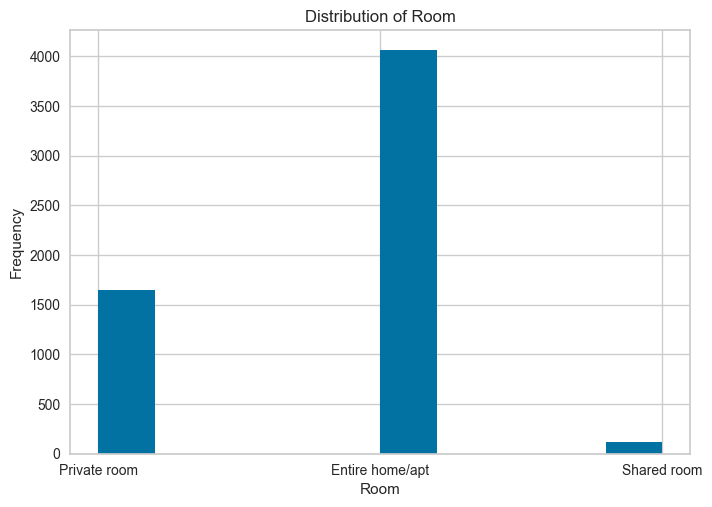

In [235]:
data['room_type'].hist()

# add labels and title
plt.xlabel('Room')
plt.ylabel('Frequency')
plt.title('Distribution of Room')

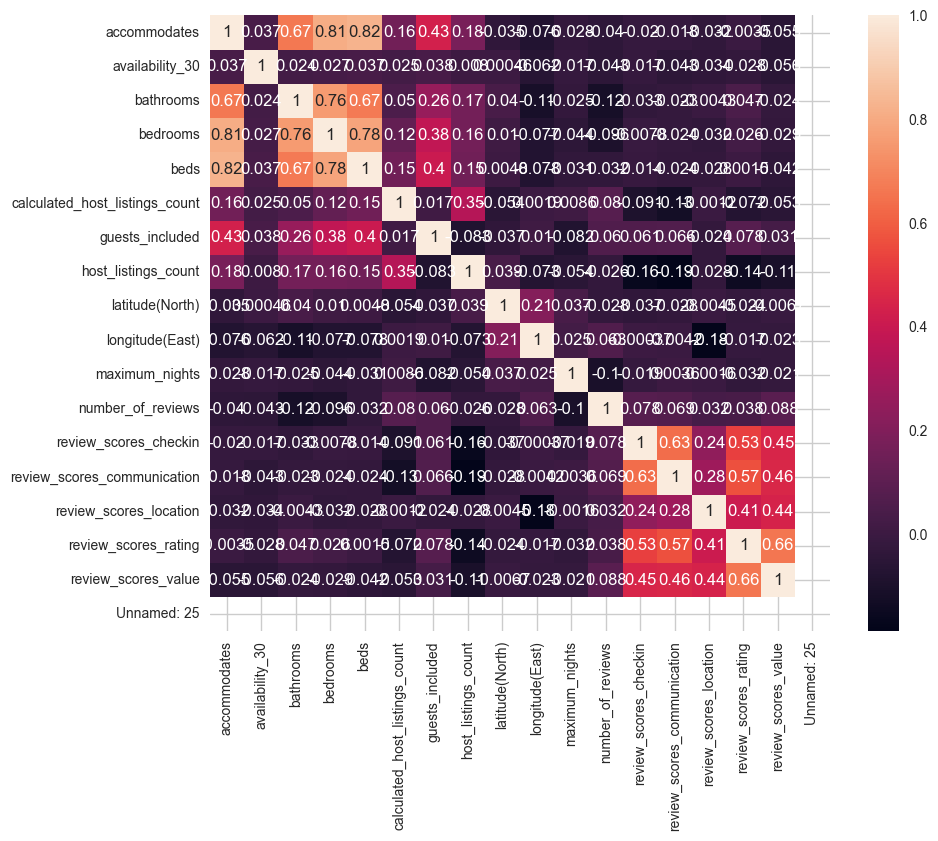

In [236]:
import seaborn as sns
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn (optional but recommended)
sns.heatmap(correlation_matrix, annot=True, cmap='rocket')
plt.show()

After looking at the csv file, it is shown that every column in "has_availability" has the same value of "t" hence the column will be removed.

I will also remove outliers in the "host_listing_count" as some values are way above the norm such as 301 and 339

in "host_is_superhost", "instant_bookable" column, since the values are 't' or 'f' the values will be replaced to 1 and 0

"maximum_nights" will be filtered down to have a maximum value of 365 as there are "interesting" values such as 9999 and 26000

next, columns such as "bed_type", "cancellation_policy", "property_type", "room_type" will be converted to categorical values

lastly the "amenities" column will be dropped for convenience sakes

if everything seems correct, the final dataframe will have 1424 rows

In [237]:
data.shape

(5834, 27)

In [238]:
# changing the format of the price from $300.00 to 300.00
data['price'] = data['price'].replace('[^\d.]','',regex=True)

#drop columns
data = data.drop(columns='Unnamed: 25')
data = data.dropna()
data = data.drop(columns=['has_availability','amenities','longitude(East)','latitude(North)'])

#filtering data
data = data[data['host_listings_count'] < 50]
data = data[data['maximum_nights'] <= 365]

#replacing string to binary
data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0})
data['instant_bookable'] = data['instant_bookable'].replace({'t': 1, 'f': 0})

#replacing string with categorical values
data['bed_type'] = data['bed_type'].astype('object')
data['cancellation_policy'] = data['cancellation_policy'].astype('object')
data['property_type'] = data['property_type'].astype('object')
data['room_type'] = data['room_type'].astype('object')

data['price'] = data['price'].astype(float).astype(int)


In [239]:
data.shape
data = data.reset_index()

In [240]:
data = data.drop(columns=['index'])

In [241]:
data.head()

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,cancellation_policy,guests_included,host_is_superhost,...,maximum_nights,number_of_reviews,property_type,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,price
0,6,0,2.5,Real Bed,1.0,3.0,1,moderate,1,0,...,10,1,House,10.0,10.0,10.0,100.0,10.0,Private room,300
1,2,16,1.0,Real Bed,1.0,1.0,1,moderate,2,0,...,7,2,House,10.0,10.0,10.0,100.0,10.0,Private room,40
2,2,25,1.0,Real Bed,1.0,1.0,5,strict,1,1,...,14,4,House,10.0,10.0,10.0,100.0,10.0,Private room,49
3,6,19,1.0,Real Bed,1.0,2.0,1,moderate,4,0,...,30,76,House,10.0,10.0,9.0,94.0,10.0,Private room,50
4,2,19,1.5,Real Bed,1.0,2.0,2,strict,2,1,...,28,14,House,10.0,10.0,9.0,99.0,10.0,Private room,49


In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    1424 non-null   int64  
 1   availability_30                 1424 non-null   int64  
 2   bathrooms                       1424 non-null   float64
 3   bed_type                        1424 non-null   object 
 4   bedrooms                        1424 non-null   float64
 5   beds                            1424 non-null   float64
 6   calculated_host_listings_count  1424 non-null   int64  
 7   cancellation_policy             1424 non-null   object 
 8   guests_included                 1424 non-null   int64  
 9   host_is_superhost               1424 non-null   int64  
 10  host_listings_count             1424 non-null   float64
 11  instant_bookable                1424 non-null   int64  
 12  maximum_nights                  14

In [243]:
from pycaret.regression import *
s = setup(data, target='price',train_size=0.8, normalize = True, session_id = 123, fold = 10, experiment_name = 'homes_v2')

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(1424, 22)"
4,Transformed data shape,"(1424, 44)"
5,Transformed train set shape,"(1139, 44)"
6,Transformed test set shape,"(285, 44)"
7,Numeric features,17
8,Categorical features,4
9,Preprocess,True


In [245]:
test = s.get_config('dataset_transformed')
test

,accommodates,availability_30,bathrooms,bed_type_Real Bed,bed_type_Futon,bed_type_Airbed,bed_type_Pull-out Sofa,bed_type_Couch,bedrooms,beds,...,property_type_Boat,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price
1286,-0.157826,0.648146,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,-0.629298,0.398302,...,-0.029643,0.247003,0.249783,0.690535,0.663423,0.658289,0.640042,-0.612865,-0.13369,140
1140,-0.157826,1.172153,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,-0.629298,-0.155625,...,-0.029643,0.247003,0.249783,0.690535,0.165856,-0.539461,-1.562398,1.631680,-0.13369,80
599,-0.157826,-1.447882,0.806448,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,0.222986,-0.709551,...,-0.029643,0.247003,0.249783,0.690535,0.497567,-0.539461,0.640042,-0.612865,-0.13369,550
962,-0.157826,0.386143,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,0.222986,-0.155625,...,-0.029643,0.247003,0.249783,0.690535,0.497567,0.658289,0.640042,-0.612865,-0.13369,299
613,-0.857296,-0.225199,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,-0.629298,-0.709551,...,-0.029643,0.247003,0.249783,0.690535,0.165856,0.658289,0.640042,-0.612865,-0.13369,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,-0.857296,1.172153,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,-0.629298,-0.709551,...,-0.029643,0.247003,0.249783,-0.611650,0.165856,0.658289,-1.562398,1.631680,-0.13369,65
388,-0.157826,-0.050530,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,-0.629298,-0.155625,...,-0.029643,0.247003,0.249783,-0.611650,0.331711,0.658289,0.640042,-0.612865,-0.13369,95
1117,2.640055,0.473477,0.806448,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,1.927553,4.275788,...,-0.029643,0.247003,0.249783,0.690535,0.331711,0.658289,0.640042,-0.612865,-0.13369,329
1027,-0.857296,0.997484,-0.605611,0.214275,-0.126717,-0.137053,-0.078637,-0.059365,-0.629298,-0.709551,...,-0.029643,0.247003,0.249783,-0.611650,0.663423,0.658289,0.640042,-0.612865,-0.13369,200


In [246]:
best = compare_models(errors='raise')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,99.9964,35329.7658,183.6748,0.5643,0.5363,0.5352,0.6040
lightgbm,Light Gradient Boosting Machine,103.7789,36622.4486,186.4286,0.5559,0.5746,0.5736,0.1150
rf,Random Forest Regressor,102.3687,36535.0535,186.6129,0.5487,0.5371,0.5908,0.2120
gbr,Gradient Boosting Regressor,100.6030,37091.2791,187.9476,0.5419,0.5239,0.5264,0.1090
et,Extra Trees Regressor,105.8933,38877.6192,190.8900,0.5315,0.5501,0.5919,0.2050
xgboost,Extreme Gradient Boosting,107.6024,38647.1003,193.1093,0.5144,0.5690,0.5616,0.0910
br,Bayesian Ridge,114.5129,40991.9331,195.7995,0.5083,0.7417,0.7281,0.0520
en,Elastic Net,109.9895,42038.4818,197.6365,0.5058,0.6532,0.6655,0.0800
lasso,Lasso Regression,115.4753,41254.8671,196.5050,0.5033,0.7539,0.7422,0.0850
llar,Lasso Least Angle Regression,115.4754,41254.7340,196.5046,0.5033,0.7538,0.7423,0.0580


In [247]:
best.get_params()

{'loss_function': 'RMSE',
 'border_count': 254,
 'verbose': False,
 'task_type': 'CPU',
 'random_state': 123}

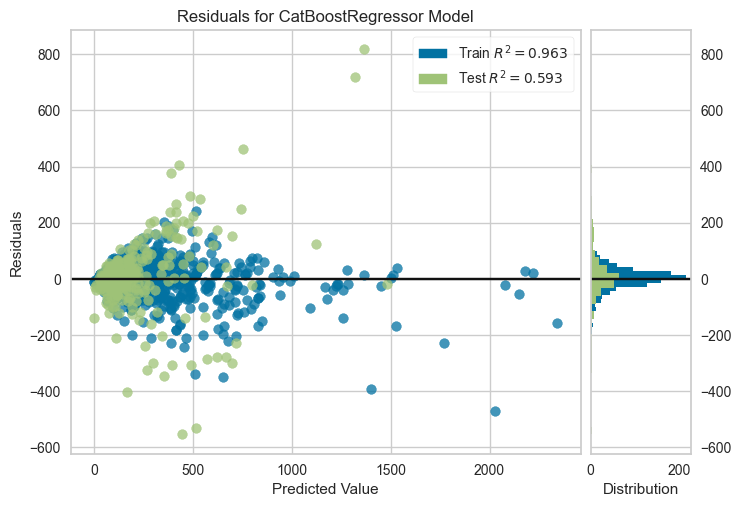

In [248]:
plot_model(best, plot='residuals')

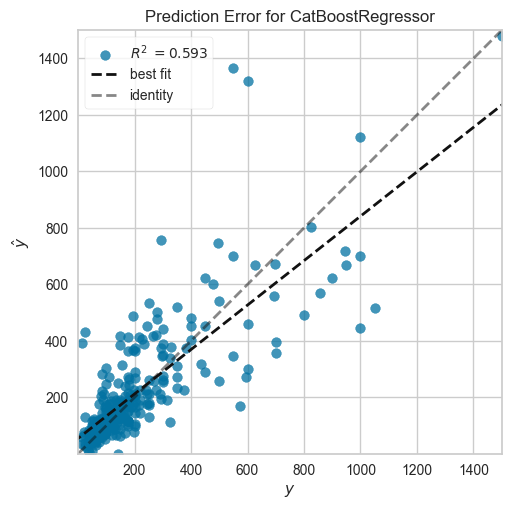

In [249]:
plot_model(best,plot='error')

In [250]:
tuned = tune_model(best, return_tuner=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,92.8895,48386.6823,219.9697,0.6002,0.5163,0.5367
1,97.0636,29846.1482,172.7604,0.6330,0.5057,0.5234
2,91.0908,19436.6470,139.4154,0.7054,0.5933,0.7046
3,98.0706,24190.4007,155.5326,0.5635,0.4851,0.4759
4,112.8361,29880.2666,172.8591,0.2296,0.7538,1.1094
5,125.4100,90703.8444,301.1708,0.4492,0.5905,0.5995
6,97.0525,34371.7802,185.3963,0.6085,0.4680,0.4375
7,94.8158,25149.8089,158.5869,0.6957,0.4757,0.4132
8,84.8668,16664.7570,129.0920,0.7032,0.4848,0.4682


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [251]:
best_tuned = tuned[0]

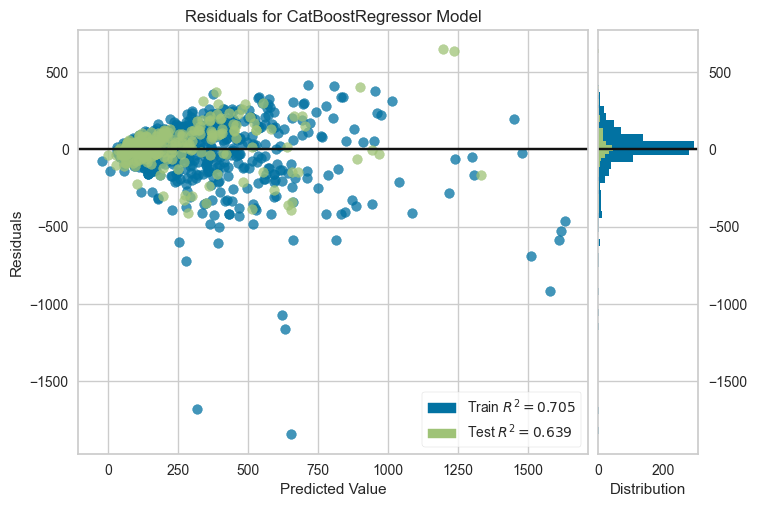

In [252]:
plot_model(best_tuned, plot='residuals')

In [253]:
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,78.5530,18247.1892,135.0822,0.5930,0.6080,0.5873


In [254]:
holdout_pred.head()

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,cancellation_policy,guests_included,host_is_superhost,...,number_of_reviews,property_type,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,price,prediction_label
1184,6,23,1.0,Real Bed,2.0,2.0,4,strict,7,0,...,49,House,10.0,10.0,10.0,95.0,9.0,Entire home/apt,165,205.454042
1422,4,6,1.0,Real Bed,1.0,2.0,2,strict,2,0,...,195,Apartment,10.0,10.0,10.0,96.0,9.0,Entire home/apt,150,125.892000
980,4,5,2.0,Real Bed,1.0,2.0,1,strict,2,0,...,2,Apartment,9.0,7.0,8.0,80.0,8.0,Private room,90,211.848665
969,4,16,1.0,Real Bed,1.0,1.0,2,strict,2,1,...,37,House,10.0,10.0,10.0,97.0,9.0,Private room,129,86.159172
320,3,7,1.0,Real Bed,1.0,1.0,1,moderate,2,0,...,15,Apartment,10.0,10.0,10.0,100.0,10.0,Entire home/apt,175,116.463232


In [255]:
save_model(best, 'homely_resort')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['accommodates', 'availability_30',
                                              'bathrooms', 'bedrooms', 'beds',
                                              'calculated_host_listings_count',
                                              'guests_included',
                                              'host_is_superhost',
                                              'host_listings_count',
                                              'instant_bookable',
                                              'maximum_nights',
                                              'number_of_reviews',
                                              'review_scores_checkin',
                                              'review_scores_commu...
                  TransformerWrapper(include=['bed_type', 'cancellation_policy',
                                              'property_type'

In [256]:
load_pipeline = load_model('homely_resort')
load_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\ZUDEAN~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['accommodates', 'availability_30',
                                             'bathrooms', 'bedrooms', 'beds',
                                             'calculated_host_listings_count',
                                             'guests_included',
                                             'host_is_superhost',
                                             'host_listings_count',
                                             'instant_bookable',
                                             'maximum_nights',
                                             'number_of_reviews',
                                             '...
                 TransformerWrapper(include=['bed_type', 'cancellation_policy',
                                             'property_type', 'room_type'],
                                    transformer=OneHotEncoder(cols=['bed_type',
                                                                    'cancellation_policy',
                                                                    'property_type',
                                                                    'room_type'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x000001BA01CB0520>)])

In [216]:
!mlflow ui

^C


In [217]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.set_experiment(experiment_id="239846606708982393")

<Experiment: artifact_location='mlflow-artifacts:/239846606708982393', creation_time=1708696542899, experiment_id='239846606708982393', last_update_time=1708696542899, lifecycle_stage='active', name='homes_v2', tags={}>

In [218]:
y_true = holdout_pred['price']
y_pred = holdout_pred['prediction_label']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
mlflow.end_run()


# Start an MLflow run
with mlflow.start_run() as run:
    mlflow.log_param('train_size', 0.8)
    mlflow.log_param('fold',10)
    
    # Log metrics
    mlflow.log_metric('MAE', mae)
    mlflow.log_metric('MSE', mse)
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('R2', r2)
    
    # Set the experiment name (note: this should be set before logging parameters)
    mlflow.set_experiment('homes_v2')
    mlflow.log_param('experiment_name', 'homes_v2')
    mlflow.log_param('run_id', run.info.run_id)
    
    
    # Log the Sklearn model
    mlflow.sklearn.log_model(sk_model=best_tuned, registered_model_name='homes_v2', artifact_path='sk_model')

Registered model 'homes_v2' already exists. Creating a new version of this model...
2024/02/24 03:13:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: homes_v2, version 6
Created version '6' of model 'homes_v2'.


In [219]:
data.shape

(1424, 22)

In [221]:
pip show scikit-learn

Name: scikit-learn
Version: 1.4.1.post1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\zude ang\anaconda3\envs\test\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: category-encoders, dtreeviz, evidently, explainerdashboard, fairlearn, imbalanced-learn, interpret-core, kmodes, mlflow, mlxtend, pmdarima, pycaret, pynndescent, pyod, scikit-learn-intelex, scikit-optimize, scikit-plot, shap, sktime, tbats, tune-sklearn, umap-learn, yellowbrick
Note: you may need to restart the kernel to use updated packages.
